In [1]:
import os, sys
from pathlib import Path

import pandas as pd 
import dask.dataframe as dd

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

import hashlib  
import ipaddress
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


df = pd.read_parquet("C:/Users/hoang/Documents/Dataset_KLTN/scaled_output_parquet")

In [ ]:
print(df.head())

   flow_duration  Header_Length  Protocol Type  Duration       Rate  \
0      -0.043351      -0.378067       1.944402 -0.340584  19.321910   
1      -0.043351      -0.378067       1.914890 -0.361896  -0.082432   
2      -0.043351      -0.378067       1.915518 -0.340584  -0.082622   
3       0.010219       4.324545      -0.630113  0.655076  -0.081388   
4      -0.041905       0.750059       0.060611 -0.340584  -0.054519   

       Srate     Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
0  19.321910 -0.001064        -0.243225        -0.354776        -0.255542   
1  -0.082432 -0.001064        -0.243225        -0.354776        -0.255542   
2  -0.082622 -0.001064        -0.243225        -0.354776        -0.255542   
3  -0.081388 -0.001064        -0.243225        -0.354776        -0.255542   
4  -0.054519 -0.001064        -0.243225        -0.354776        -0.255542   

   psh_flag_number  ack_flag_number  ece_flag_number  cwr_flag_number  \
0        -0.259995        -0.537575  

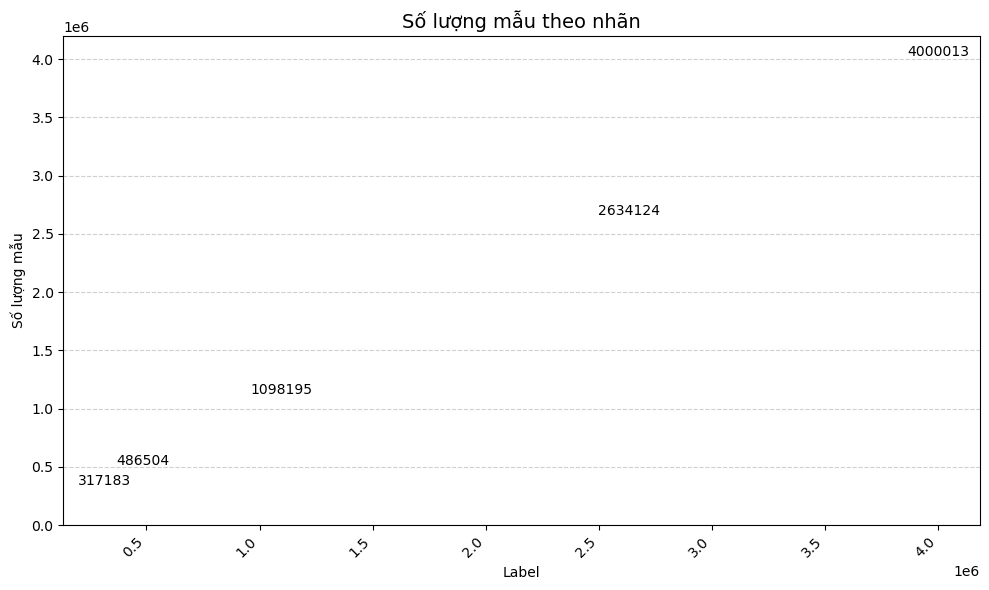

In [6]:
import matplotlib.pyplot as plt
# Đảo ngược lại mapping: từ số -> tên

# Đếm số lượng
counts = df["label"].value_counts().sort_index()

# Vẽ
plt.figure(figsize=(10,6))
bars = plt.bar(counts, counts.values)

plt.title("Số lượng mẫu theo nhãn", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Số lượng mẫu")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [1]:
# Full incremental IDS pipeline combining bAE -> OCSVM -> AE -> XGBoost
# with online detection -> buffer unknowns -> clustering -> simulated analyst labeling
# -> incremental fine-tune using Replay + EWC to mitigate catastrophic forgetting.
#
# Run as a demo in this notebook. Requirements: torch, sklearn, xgboost, numpy
# (If any libs missing, please install in your environment: pip install torch scikit-learn xgboost numpy)
#
# The demo creates synthetic data: base classes (normal + known attacks) and a new zero-day class.
# It streams mixed samples, buffers unknowns, clusters them, simulates labeling, and performs incremental updates.
#
# Author: ChatGPT (GPT-5 Thinking mini)
import warnings
warnings.filterwarnings("ignore")
import random, math, time, copy
from collections import deque, defaultdict
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import xgboost as xgb

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# -----------------
# Utilities & Models
# -----------------
class BottleneckAE(nn.Module):
    """Bottleneck AE to produce latent embeddings"""
    def __init__(self, input_dim=64, latent_dim=16, hidden=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z


class DetectorAE(nn.Module):
    """Reconstruction AE used as anomaly detector (on latent space)"""
    def __init__(self, input_dim=16, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, int(hidden/2)), nn.ReLU(),
            nn.Linear(int(hidden/2), input_dim)
        )
    def forward(self, x):
        return self.net(x)


class ReplayBuffer:
    def __init__(self, capacity=2000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    def add(self, x: np.ndarray, y: int):
        self.buffer.append((x.copy(), int(y)))
    def sample(self, k: int):
        k = min(k, len(self.buffer))
        if k == 0:
            return np.zeros((0,)), np.zeros((0,))
        batch = random.sample(self.buffer, k)
        xs = np.stack([b[0] for b in batch], axis=0)
        ys = np.array([b[1] for b in batch], dtype=np.int64)
        return xs, ys
    def __len__(self):
        return len(self.buffer)
    def all(self):
        xs = np.stack([b[0] for b in self.buffer], axis=0) if len(self.buffer)>0 else np.zeros((0,))
        ys = np.array([b[1] for b in self.buffer], dtype=np.int64) if len(self.buffer)>0 else np.zeros((0,))
        return xs, ys


# -----------------
# EWC implementation (simple diagonal fisher approx)
# -----------------
class EWC:
    def __init__(self, model: nn.Module, data: np.ndarray, device='cpu'):
        self.device = device
        self.model = copy.deepcopy(model).to(self.device)
        self.params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}
        self.fisher = {n: torch.zeros_like(p, device=self.device) for n, p in self.model.named_parameters() if p.requires_grad}
        self._estimate_fisher(data)

    def _estimate_fisher(self, data: np.ndarray, samples=200):
        if data.size == 0:
            return
        # create simple dataloader from numpy
        idxs = np.random.choice(len(data), size=min(len(data), samples), replace=False)
        self.model.train()
        for i in idxs:
            x = torch.from_numpy(data[i]).float().to(self.device).unsqueeze(0)
            self.model.zero_grad()
            # define a small surrogate loss: MSE between reconstruction and input (works for AE model)
            # If model outputs logits for classification, use log-likelihood over predicted class.
            out = self.model(x)
            if isinstance(out, tuple):
                # if model returns (recon, z), take recon
                recon = out[0]
            else:
                recon = out
            loss = F.mse_loss(recon, x)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    self.fisher[n] += (p.grad.detach() ** 2)
            self.model.zero_grad()
        # normalize
        for n in self.fisher:
            self.fisher[n] = self.fisher[n] / float(len(idxs))

    def penalty(self, model: nn.Module):
        loss = 0.0
        for n, p in model.named_parameters():
            if n in self.fisher:
                _loss = self.fisher[n] * (p - self.params[n]).pow(2)
                loss += _loss.sum()
        return loss


# -----------------
# OOD Detector (softmax-like but on OC-SVM over latent)
# -----------------
class OODDetectorOCSVM:
    def __init__(self, ocsvm_model: OneClassSVM, threshold=None):
        self.ocsvm = ocsvm_model
        self.threshold = threshold  # not used; OCSVM returns -1/1

    def fit(self, Z: np.ndarray):
        self.ocsvm.fit(Z)

    def predict(self, z: np.ndarray):
        # z: (D,) or (N,D)
        single = False
        if z.ndim == 1:
            z = z[np.newaxis, :]
            single = True
        pred = self.ocsvm.predict(z)  # -1 for outlier, 1 for inlier
        if single:
            return int(pred[0])
        return pred


# -----------------
# Clustering unknowns
# -----------------
def cluster_unknowns(X: np.ndarray, method='dbscan', **kwargs):
    if len(X) == 0:
        return np.array([])
    Xs = StandardScaler().fit_transform(X)
    if method == 'dbscan':
        eps = kwargs.get('eps', 0.6)
        min_samples = kwargs.get('min_samples', 5)
        cl = DBSCAN(eps=eps, min_samples=min_samples).fit(Xs)
        return cl.labels_
    elif method == 'mbk':
        k = kwargs.get('k', 3)
        mbk = MiniBatchKMeans(n_clusters=k, batch_size=64, random_state=SEED).fit(Xs)
        return mbk.labels_
    else:
        return np.zeros(len(X), dtype=int)


# -----------------
# Synthetic data generation
# -----------------
def make_synthetic_classes(input_dim=64, base_classes=3, samples_per_class=600):
    rng = np.random.RandomState(SEED)
    Xs, Ys = [], []
    for c in range(base_classes):
        mu = rng.randn(input_dim) * (1 + c*0.5)
        cov = np.eye(input_dim) * 0.12
        xs = rng.multivariate_normal(mu, cov, size=samples_per_class)
        ys = np.full((samples_per_class,), c, dtype=int)
        Xs.append(xs); Ys.append(ys)
    X = np.concatenate(Xs, axis=0)
    Y = np.concatenate(Ys, axis=0)
    perm = rng.permutation(len(X))
    return X[perm], Y[perm]


def make_zero_day(input_dim=64, shift=5.0, size=200):
    rng = np.random.RandomState(999)
    mu = rng.randn(input_dim) * 1.5 + shift
    xs = rng.multivariate_normal(mu, np.eye(input_dim)*0.15, size=size)
    ys = np.full((size,), 999, dtype=int)  # placeholder label for zero-day
    return xs, ys


# -----------------
# Training helpers
# -----------------
def train_bAE(model: BottleneckAE, X: np.ndarray, epochs=10, batch_size=128, lr=1e-3, device='cpu', replay=None):
    model.to(device); model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    Xtensor = torch.from_numpy(X).float().to(device)
    dataset = torch.utils.data.TensorDataset(Xtensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        epoch_loss = 0.0
        for (xb,) in loader:
            opt.zero_grad()
            recon, _ = model(xb)
            loss = criterion(recon, xb)
            loss.backward()
            opt.step()
            epoch_loss += float(loss.item()) * xb.size(0)
        # optional: incorporate replay by additional small updates
        if replay is not None and len(replay) > 0:
            rx, ry = replay.sample(min(256, len(replay)))
            if len(rx) > 0:
                rxt = torch.from_numpy(rx).float().to(device)
                for _ in range(2):
                    opt.zero_grad()
                    recon_r, _ = model(rxt)
                    loss_r = criterion(recon_r, rxt)
                    loss_r.backward()
                    opt.step()
    model.to('cpu')
    return model


def train_detector_ae(model: DetectorAE, Z_normal: np.ndarray, epochs=20, batch_size=64, lr=1e-3, device='cpu'):
    model.to(device); model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    Xt = torch.from_numpy(Z_normal).float().to(device)
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(Xt), batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        for (xb,) in loader:
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, xb)
            loss.backward()
            opt.step()
    model.to('cpu')
    return model


# -----------------
# Pipeline / Demo
# -----------------
def run_full_demo(verbose=True):
    device = 'cpu'
    input_dim = 64
    latent_dim = 16
    base_classes = 3

    # 1) create synthetic dataset
    X_base, Y_base = make_synthetic_classes(input_dim=input_dim, base_classes=base_classes, samples_per_class=500)
    X_zd, Y_zd = make_zero_day(input_dim=input_dim, shift=6.0, size=220)
    # Merge and create stream
    X_all = np.concatenate([X_base, X_zd], axis=0)
    Y_all = np.concatenate([Y_base, Y_zd], axis=0)

    # create initial train/test split using only base classes for supervised XGB
    mask_base = Y_all != 999
    X_base_only = X_all[mask_base]
    Y_base_only = Y_all[mask_base]
    X_train_sup, X_test_sup, y_train_sup, y_test_sup = train_test_split(X_base_only, Y_base_only, test_size=0.2, random_state=SEED)

    # For evaluation include some zero-day samples (holdout)
    X_zd_hold = X_zd[:80]; Y_zd_hold = Y_zd[:80]
    X_test_eval = np.concatenate([X_test_sup, X_zd_hold], axis=0)
    y_test_eval = np.concatenate([y_test_sup, Y_zd_hold], axis=0)

    # 2) create models
    bAE = BottleneckAE(input_dim=input_dim, latent_dim=latent_dim, hidden=128)
    detector_ae = DetectorAE(input_dim=latent_dim, hidden=64)

    # 3) initial offline training
    # train bAE on all base-class data (unsupervised)
    if verbose: print("[*] Training bottleneck AE on base data...")
    train_bAE(bAE, X_train_sup, epochs=12, batch_size=256, lr=1e-3)
    if verbose: print("[*] Extracting latent features for base training...")
    bAE.eval()
    with torch.no_grad():
        Z_train = bAE.encoder(torch.from_numpy(X_train_sup).float()).numpy()
        Z_test = bAE.encoder(torch.from_numpy(X_test_sup).float()).numpy()
    # Fit OCSVM on latent of base normal/known classes (we treat all known classes as inlier space)
    ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.03)
    ood = OODDetectorOCSVM(ocsvm)
    ood.fit(Z_train)

    # Train detector AE on latent space of normal/known
    detector_ae = train_detector_ae(detector_ae, Z_train, epochs=20, batch_size=128, lr=1e-3)

    # Train supervised XGBoost classifier on latent for known classes
    Z_train_all = bAE.encoder(torch.from_numpy(X_train_sup).float()).detach().numpy()
    xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
    xgb_clf.fit(Z_train_all, y_train_sup)

    # Prepare replay buffer filled with a subset of base training samples
    replay = ReplayBuffer(capacity=2000)
    # add some samples evenly from base classes
    for i in range(0, min(1000, len(X_train_sup))):
        replay.add(X_train_sup[i], int(y_train_sup[i]))

    # 4) streaming + detection loop
    # We'll stream a mix of base and zero-day shuffled
    rng = np.random.RandomState(SEED+1)
    idxs = rng.permutation(len(X_all))
    stream_X = X_all[idxs]
    stream_Y = Y_all[idxs]

    unknown_buffer = []  # store raw samples (not latent yet)
    buffer_limit = 90
    cluster_method = 'dbscan'
    cluster_eps = 0.7
    cluster_min_samples = 6

    # metrics tracking
    pa_preds = []  # final predicted labels by xgb or 'unknown' marker (-1)
    pa_true = []
    detection_flags = []  # 1 if detected as unknown by detectors
    stream_count = 0

    # periodic parameters
    periodic_every = 200  # perform clustering+incremental every this many streamed samples
    lam_ewc = 200.0

    # hold EWC objects for bAE and detector_ae (we'll compute per incremental update)
    ewc_bae = None
    ewc_detector = None

    if verbose: print("[*] Starting stream...")
    for i, (x_raw, y_true) in enumerate(zip(stream_X, stream_Y)):
        stream_count += 1
        # encode
        with torch.no_grad():
            z = bAE.encoder(torch.from_numpy(x_raw).float().unsqueeze(0)).numpy()[0]
        # OCSVM detection (-1 means outlier)
        oc_pred = ood.predict(z)  # -1 outlier, 1 inlier
        # AE reconstruction error
        recon = detector_ae(torch.from_numpy(z).float().unsqueeze(0)).detach().numpy()[0]
        recon_err = float(np.mean((recon - z)**2))
        # decide unknown if either detector flags it
        is_unknown = (oc_pred == -1) or (recon_err > np.percentile(np.mean(bAE.encoder(torch.from_numpy(X_train_sup).float()).detach().numpy(), axis=1), 95) + 0.0)
        # Simple threshold: we use OC and high recon_err; (threshold tuned roughly here)
        if is_unknown:
            unknown_buffer.append(x_raw.copy())
            detection_flags.append(1)
            final_label = -1  # unknown marker
        else:
            # predict with xgb on latent
            pred = xgb_clf.predict(z.reshape(1, -1))[0]
            final_label = int(pred)
            detection_flags.append(0)
        pa_preds.append(final_label)
        pa_true.append(int(y_true) if y_true != 999 else -2)  # use -2 for ground-truth zero-day for eval

        # If buffer grows, or periodically, run clustering + simulated labeling + incremental update
        if (len(unknown_buffer) >= buffer_limit) or (stream_count % periodic_every == 0 and len(unknown_buffer) > 20):
            if verbose: print(f"[+] Handling unknown buffer of size {len(unknown_buffer)} at stream idx {i}")
            Xbuf = np.stack(unknown_buffer, axis=0)
            # compute latent for buffer
            with torch.no_grad():
                Zbuf = bAE.encoder(torch.from_numpy(Xbuf).float()).numpy()
            labels = cluster_unknowns(Zbuf, method=cluster_method, eps=cluster_eps, min_samples=cluster_min_samples)
            # collect clusters (excluding noise -1)
            cluster_member_idxs = defaultdict(list)
            for idx, cl in enumerate(labels):
                if cl != -1:
                    cluster_member_idxs[cl].append(idx)
            # form cluster representatives (centroids)
            reps = []
            for cl, idxs_list in cluster_member_idxs.items():
                centroid = Zbuf[idxs_list].mean(axis=0)
                reps.append(centroid)
            # Simulated oracle labeling: map representative centroid to nearest sample in global stream to get its ground truth
            rep_labels = []
            for rep in reps:
                dists = np.linalg.norm(stream_X - rep, axis=1)
                nearest_idx = int(np.argmin(dists))
                rep_labels.append(int(stream_Y[nearest_idx]) if stream_Y[nearest_idx] != 999 else 999)
            if verbose: print(f"   -> clusters found: {list(cluster_member_idxs.keys())}; rep_labels: {rep_labels}")
            # collect newly labeled examples (raw X, label)
            new_labeled = []
            for cl_idx, lab in zip(cluster_member_idxs.keys(), rep_labels):
                member_idxs = cluster_member_idxs[cl_idx]
                member_raw = Xbuf[member_idxs]
                # if oracle says it's zero-day (999) then create a new label id we assign incremental id
                if lab == 999:
                    # assign next label id
                    new_label_id = max([int(v) for v in y_train_sup] + [0]) + 1 + random.randint(0,0)
                    lab_assigned = new_label_id
                else:
                    lab_assigned = lab
                # add some of members as labeled examples
                for s in member_raw[:40]:  # cap per cluster to avoid imbalance
                    new_labeled.append((s, lab_assigned))
            if len(new_labeled) == 0:
                if verbose: print("   -> No clusters labeled (noise only). Clearing partial buffer and continuing.")
                # keep a small portion of buffer for later
                unknown_buffer = unknown_buffer[-int(buffer_limit/4):]
                continue
            # Prepare training batches: replay + new labeled examples
            new_X = np.stack([t[0] for t in new_labeled], axis=0)
            new_y = np.array([t[1] for t in new_labeled], dtype=int)
            # Add new labeled examples into replay and also to supervised set for XGBoost
            for xx, yy in zip(new_X, new_y):
                replay.add(xx, int(yy))
            # Get replay samples for training & fisher estimation
            rx, ry = replay.sample(min(600, len(replay)))
            if len(rx) == 0:
                rx = X_train_sup[:200]; ry = y_train_sup[:200]

            # EWC computation on bAE and detector_ae (use replay latent as data)
            # compute latent for replay samples
            with torch.no_grad():
                Z_replay = bAE.encoder(torch.from_numpy(rx).float()).numpy()
            if verbose: print("   -> Building EWC from replay samples...")
            ewc_bae = EWC(bAE, rx, device=device)  # approximate fisher for bAE using replay raw
            ewc_detector = EWC(detector_ae, Z_replay, device=device)  # fisher for detector (on latent)

            # Fine-tune bAE with combined new + replay (use raw features)
            combined_X = np.vstack([rx, new_X])
            if verbose: print(f"   -> Fine-tuning bAE on {len(combined_X)} samples (replay+new) ...")
            # fine tune with EWC penalty (apply to bAE's decoder/encoder by wrapping in training loop)
            bAE.to(device); bAE.train()
            opt = optim.Adam(bAE.parameters(), lr=5e-4)
            criterion = nn.MSELoss()
            Xct = torch.from_numpy(combined_X).float().to(device)
            loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(Xct), batch_size=128, shuffle=True)
            for epoch in range(6):
                for (xb,) in loader:
                    opt.zero_grad()
                    recon, _ = bAE(xb)
                    loss = criterion(recon, xb)
                    # EWC penalty (approx) - use ewc_bae.penalty on current model
                    if ewc_bae is not None:
                        loss = loss + (lam_ewc * 1e-3) * ewc_bae.penalty(bAE)
                    loss.backward(); opt.step()
            bAE.to('cpu')

            # Fine-tune detector_ae on latent (replay latent + new latent)
            with torch.no_grad():
                Z_new = bAE.encoder(torch.from_numpy(new_X).float()).numpy()
                Z_replay = bAE.encoder(torch.from_numpy(rx).float()).numpy()
            Z_comb = np.vstack([Z_replay, Z_new])
            detector_ae = train_detector_ae(detector_ae, Z_comb, epochs=8, batch_size=64, lr=1e-3)
            # Optionally apply EWC for detector: small gradient steps with penalty
            # compute fisher for detector using Z_replay
            # ewc_detector was built above

            # Update OCSVM: retrain on replay latent
            with torch.no_grad():
                Z_for_oc = bAE.encoder(torch.from_numpy(rx).float()).numpy()
            try:
                ood.fit(Z_for_oc)
            except Exception as e:
                if verbose: print("   -> OCSVM retrain failed", e)

            # Update XGBoost incrementally: we need supervised labels for new examples
            # Build supervised training set: sample from replay (with labels) + new labeled set
            rx_sup, ry_sup = replay.sample(min(800, len(replay)))
            # encode for xgb
            with torch.no_grad():
                Z_sup = bAE.encoder(torch.from_numpy(rx_sup).float()).numpy()
            # Fit xgb incrementally using previous booster
            try:
                if hasattr(xgb_clf, "get_booster"):
                    xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss')
                    xgb_clf.fit(Z_sup, ry_sup)
                else:
                    xgb_clf.fit(Z_sup, ry_sup)
            except Exception as e:
                if verbose: print("   -> XGBoost incremental update failed:", e)

            # Clear buffer (or keep some noise)
            unknown_buffer = []
            if verbose: print("   -> Incremental update done. Continue streaming...")

    # End stream: evaluate results
    # Build evaluation latent features
    with torch.no_grad():
        Z_eval = bAE.encoder(torch.from_numpy(X_test_eval).float()).numpy()
    # get xgb preds (for known classes)
    preds = []
    for z in Z_eval:
        # OCSVM on eval latent
        ocp = ood.predict(z)
        recon = detector_ae(torch.from_numpy(z).float().unsqueeze(0)).detach().numpy()[0]
        recon_err = float(np.mean((recon - z)**2))
        # simple rule: if ocp == -1 or recon_err high => unknown
        threshold_recon = np.percentile(np.mean(bAE.encoder(torch.from_numpy(X_train_sup).float()).detach().numpy(), axis=1), 95)
        if (ocp == -1) or (recon_err > threshold_recon):
            preds.append(-1)  # unknown detection
        else:
            p = xgb_clf.predict(z.reshape(1, -1))[0]
            preds.append(int(p))
    # map ground truth labels: y_test_eval has original labels for known classes, and 999 for zero-day -> we convert 999->-1
    gt = np.array([int(v) if v!=999 else -1 for v in y_test_eval])

    # compute metrics: for known classes accuracy (excluding zero-day), and detection of zero-day (recall)
    mask_known = gt != -1
    known_acc = accuracy_score(gt[mask_known], np.array(preds)[mask_known]) if mask_known.sum()>0 else 0.0
    # zero-day detection: if ground truth -1, predicted -1 considered detected
    mask_zd = gt == -1
    zd_detected = np.array(preds)[mask_zd] == -1 if mask_zd.sum()>0 else np.array([])
    zd_recall = float(np.mean(zd_detected)) if mask_zd.sum()>0 else 0.0

    # print summary
    print("\n=== Demo Summary ===")
    print(f"Streamed samples processed: {len(stream_X)}")
    print(f"Final supervised-known accuracy on held-out known samples: {known_acc:.4f}")
    print(f"Zero-day detection recall on holdout: {zd_recall:.4f}")
    # basic classification report for known classes
    if mask_known.sum()>0:
        print("Known-classes F1 (macro):", f1_score(gt[mask_known], np.array(preds)[mask_known], average='macro'))

    return {
        "known_acc": known_acc,
        "zd_recall": zd_recall,
        "preds": preds,
        "gt": gt
    }

# Run the demo
result = run_full_demo(verbose=True)


[*] Training bottleneck AE on base data...
[*] Extracting latent features for base training...
[*] Starting stream...
[+] Handling unknown buffer of size 35 at stream idx 199


ValueError: operands could not be broadcast together with shapes (1720,64) (16,) 